In [ ]:
!pip install "dask>=2025.10.0" "geopandas>=1.1.1" "h5netcdf>=1.6.4" "ipykernel>=6.30.1" "matplotlib>=3.10.6" "rasterio>=1.4.3" "rioxarray>=0.19.0" "xarray>=2025.9.0" --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter_client 7.4.9
    Uninstalling jupyter_client-7.4.9:
      Successfully uninstalled jupyter_client-7.4.9
  Attempting uninstall: dask
    Found existing installation: dask 2025.9.1
    Uninstalling dask

In [ ]:
from google.colab import drive
import os
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import rasterio
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)
CORE_PATH = '/content/drive/My Drive/babe/GenHack'

Mounted at /content/drive


### 1. Admin Boundaries

In [ ]:
# Load data
gadm_path = os.path.join(CORE_PATH, 'gadm_410_europe.gpkg')
gadm_europe = gpd.read_file(gadm_path) if os.path.exists(gadm_path) else None

In [ ]:
print(gadm_europe.head(5))
print(gadm_europe.columns)


   UID GID_0 NAME_0    GID_1       NAME_1   ENGTYPE_1      GID_2    NAME_2  \
0  333   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.1_2    Brändö   
1  334   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.2_2     Föglö   
2  335   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.3_2     Kökar   
3  336   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.4_2  Kumlinge   
4  337   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.1_2  Sottunga   

      ENGTYPE_2 GID_3  ... ENGTYPE_3 GID_4 NAME_4 ENGTYPE_4 GID_5 NAME_5  \
0  Municipality        ...                                                 
1  Municipality        ...                                                 
2  Municipality        ...                                                 
3  Municipality        ...                                                 
4  Municipality        ...                                                 

  ENGTYPE_5 COUNTRY CONTINENT  \
0             Åland    Europe   
1       

Successfully aggregated to national-level boundaries.
Filtered countries: ['DEU', 'FRA', 'ITA']


<Figure size 1000x600 with 0 Axes>

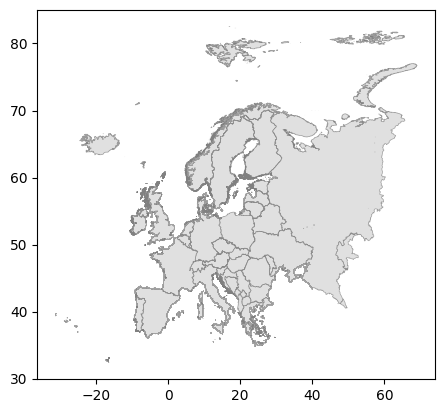

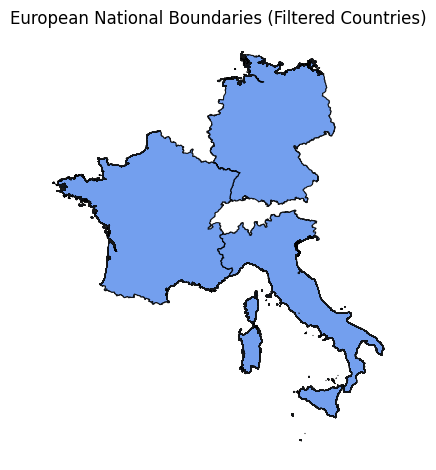

In [ ]:
# 1.2 Aggregate to national level (dissolve by country GID_0)
if gadm_europe is not None:
    # Dissolve all geometries by country (GID_0) to get national boundaries
    gadm_national = gadm_europe.dissolve(by='GID_0', aggfunc='first').reset_index() # Time-consuming process
    print("Successfully aggregated to national-level boundaries.")

    # Filter target countries
    target_countries = ['DEU', 'FRA', 'ITA']  # Use GID_0 codes (e.g., DEU=Germany, FRA=France, ITA=Italy)
    gadm_filtered = gadm_national[gadm_national['GID_0'].isin(target_countries)]
    print(f"Filtered countries: {target_countries}")

# 1.3 Visualize national-level boundaries
if gadm_europe is not None:
    plt.figure(figsize=(10, 6))
    # Background: All European countries
    gadm_national.plot(facecolor='lightgray', edgecolor='gray', linewidth=0.5, alpha=0.7)
    # Highlight: Target countries
    gadm_filtered.plot(facecolor='cornflowerblue', edgecolor='black', linewidth=0.8, alpha=0.9)
    plt.title('European National Boundaries (Filtered Countries)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### 2.Meteo

In [ ]:
!pip install cftime --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.6 MB/s eta 0:00:00


In [ ]:
meteo_path = os.path.join(CORE_PATH, 'derived-era5-land-daily-statistics')
meteo_files = [f for f in os.listdir(meteo_path) if f.endswith('.nc')] if os.path.exists(meteo_path) else []

In [ ]:
meteo_da = None
data_unit = 'm s⁻¹'  # Default unit if extraction fails

# 1. Load data and fix metadata
target_file = '2021_10m_v_component_of_wind_daily_mean.nc'
if target_file in meteo_files:
    # Load DataArray with time decoding
    meteo_da = rxr.open_rasterio(os.path.join(meteo_path, target_file), decode_times=True)
    print(f"Loaded file: {target_file}")
    print(f"Variable name: {meteo_da.name}")

    # Fix repeated units (extract first element from list/tuple)
    if 'units' in meteo_da.attrs and isinstance(meteo_da.attrs['units'], (list, tuple)):
        data_unit = meteo_da.attrs['units'][0]
    print(f"Data unit: {data_unit}")

Loaded file: 2021_10m_v_component_of_wind_daily_mean.nc
Variable name: v10
Data unit: m s**-1


In [ ]:
from cftime import DatetimeProlepticGregorian

# Time filtering (Summer 2021: Jun-Aug) - Stable time handling
temporal_dim = 'valid_time'
time_vals = meteo_da[temporal_dim].values

# Convert cftime to string -> pandas datetime (handles all cases)
if isinstance(time_vals[0], DatetimeProlepticGregorian):
    time_str = [str(t) for t in time_vals]
    meteo_da[temporal_dim] = pd.to_datetime(time_str)
else:
    meteo_da[temporal_dim] = pd.to_datetime(time_vals)

meteo_filtered = meteo_da.sel({temporal_dim: slice('2021-06-01', '2021-08-31')})

# Validate filtered data and compute mean (Stable date formatting)
if meteo_filtered.sizes[temporal_dim] > 0:
    start_date = pd.to_datetime(meteo_filtered[temporal_dim].min().item()).strftime('%Y-%m-%d')
    end_date = pd.to_datetime(meteo_filtered[temporal_dim].max().item()).strftime('%Y-%m-%d')
    print(f"Filtered time range: {start_date} to {end_date} ({meteo_filtered.sizes[temporal_dim]} days)")
    wind_mean = meteo_filtered.mean(dim=temporal_dim, skipna=True)
else:
    start_date = pd.to_datetime(meteo_da[temporal_dim].min().item()).strftime('%Y-%m-%d')
    end_date = pd.to_datetime(meteo_da[temporal_dim].max().item()).strftime('%Y-%m-%d')
    print(f"No data in selected time range. Using full 2021 dataset ({start_date} to {end_date}).")
    wind_mean = meteo_da.mean(dim=temporal_dim, skipna=True)

Filtered time range: 2021-06-01 to 2021-08-31 (92 days)


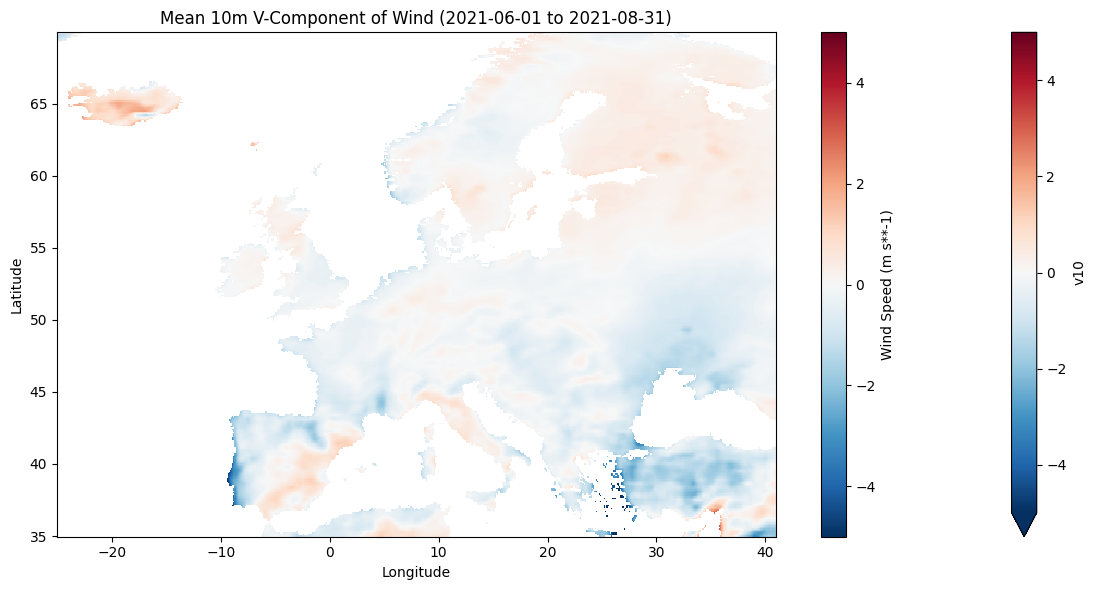

In [ ]:
# Visualization 1: Spatial distribution of mean wind speed
plt.figure(figsize=(12, 6))
im = wind_mean.plot(cmap='RdBu_r', vmin=-5, vmax=5)
plt.title(f'Mean 10m V-Component of Wind ({start_date} to {end_date})', fontsize=12)
plt.xlabel('Longitude', fontsize=10)
plt.ylabel('Latitude', fontsize=10)
plt.colorbar(im, label=f'Wind Speed ({data_unit})')
plt.tight_layout()
plt.show()

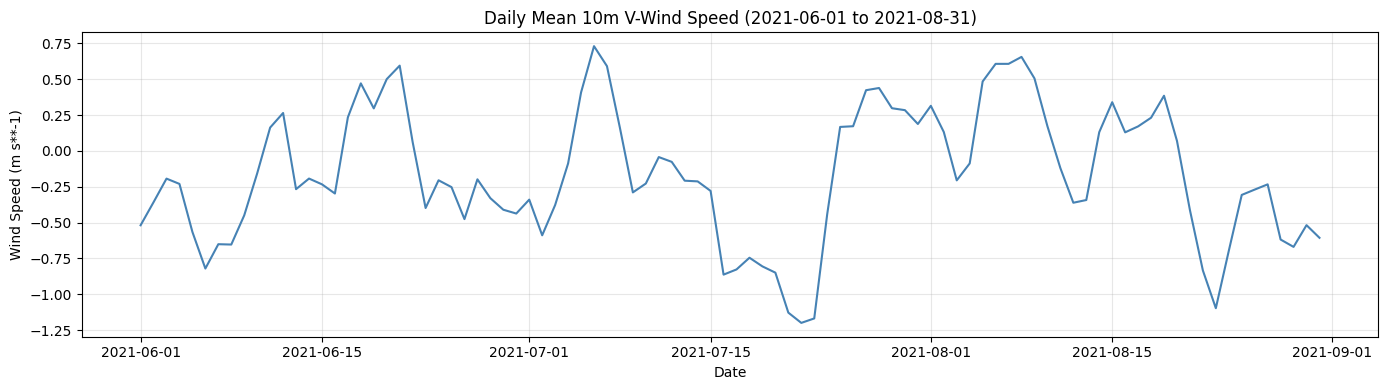

In [ ]:
# Visualization 2: Daily mean wind speed time series
if meteo_filtered.sizes[temporal_dim] > 0:
    daily_mean = meteo_filtered.mean(dim=['x', 'y'], skipna=True)
    plt.figure(figsize=(14, 4))
    plt.plot(daily_mean[temporal_dim], daily_mean.values, color='steelblue', linewidth=1.5)
    plt.title(f'Daily Mean 10m V-Wind Speed ({start_date} to {end_date})', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel(f'Wind Speed ({data_unit})', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

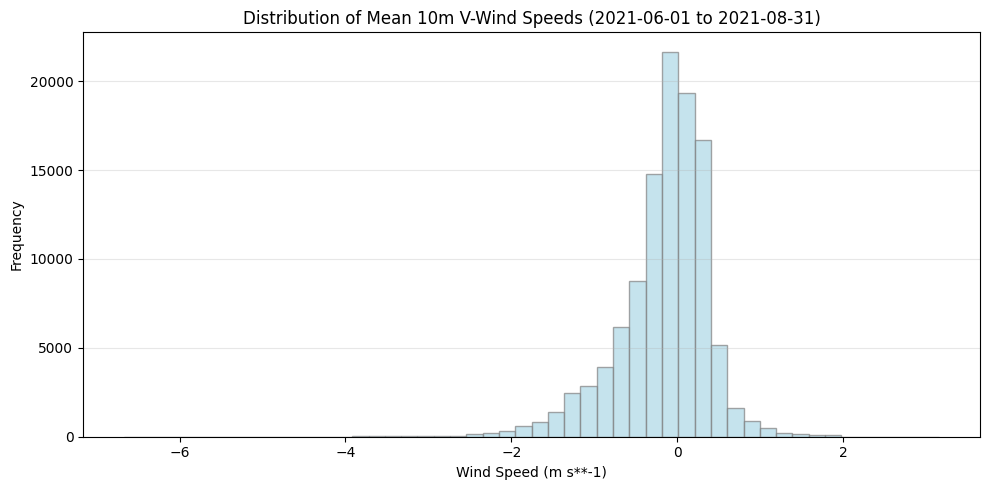

In [ ]:
# Visualization 3: Distribution of wind speeds
wind_vals = wind_mean.values.flatten()
wind_vals = wind_vals[~np.isnan(wind_vals)]
plt.figure(figsize=(10, 5))
plt.hist(wind_vals, bins=50, color='lightblue', edgecolor='gray', alpha=0.7)
plt.title(f'Distribution of Mean 10m V-Wind Speeds ({start_date} to {end_date})', fontsize=12)
plt.xlabel(f'Wind Speed ({data_unit})', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# 7. Statistical summary
print(f"\nStatistical summary for {meteo_da.name} ({start_date} to {end_date}):")
print(f"Minimum: {np.nanmin(wind_mean.values):.2f} {data_unit}")
print(f"Maximum: {np.nanmax(wind_mean.values):.2f} {data_unit}")
print(f"Mean: {np.nanmean(wind_mean.values):.2f} {data_unit}")
print(f"Standard Deviation: {np.nanstd(wind_mean.values):.2f} {data_unit}")


Statistical summary for v10 (2021-06-01 to 2021-08-31):
Minimum: -6.67 m s**-1
Maximum: 3.16 m s**-1
Mean: -0.16 m s**-1
Standard Deviation: 0.57 m s**-1


### 3. Vegetation

In [9]:
from google.colab import drive
import os
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import rasterio
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)
CORE_PATH = '/content/drive/My Drive/babe/GenHack'

Mounted at /content/drive


In [ ]:
# Load data + convert to real scale
ndvi_path = os.path.join(CORE_PATH, 'sentinel2_ndvi')
ndvi_files = [f for f in os.listdir(ndvi_path) if f.endswith('.tif')] if os.path.exists(ndvi_path) else []

Original int8 value range: 2.0 to 255.0
Number of non-255 pixels: 48844934 / 49000000

Loaded NDVI file: ndvi_2019-12-01_2020-03-01.tif
Optimized data shape: (7000, 7000) (original full size: 52389×61776)
NDVI value range: -0.98 to 0.98
NDVI filtered: Vegetated areas (NDVI > 0.3)


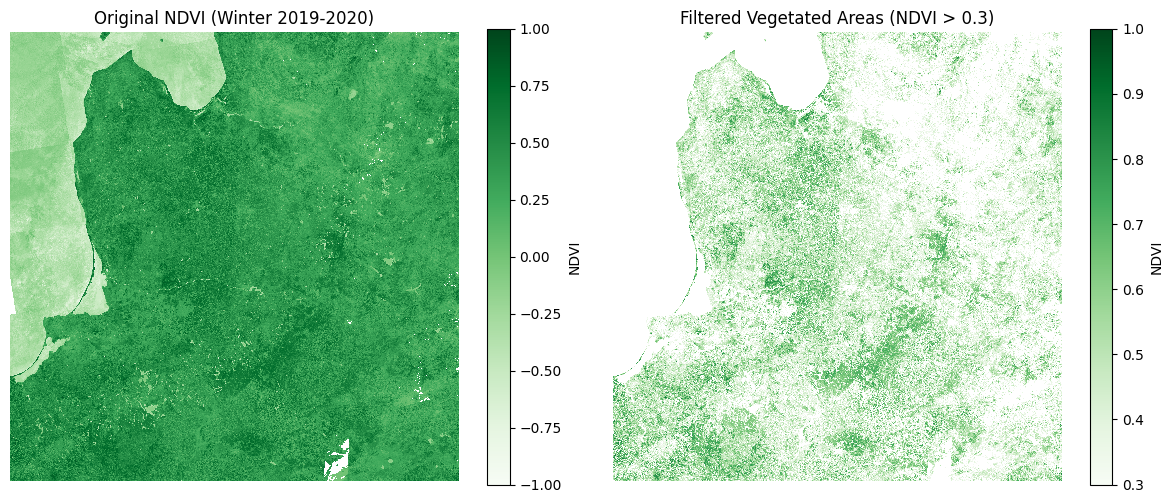


NDVI Statistical Summary:
Minimum NDVI: -0.98
Maximum NDVI: 0.98
Mean NDVI: 0.29
Percentage of Vegetated Areas (NDVI > 0.3): 58.7%


In [ ]:
ndvi_real = None

target_ndvi_file = ndvi_files[0]
with rasterio.open(os.path.join(ndvi_path, target_ndvi_file)) as src:
    window = rasterio.windows.Window.from_slices((20000, 27000), (30000, 37000))
    ndvi_int8 = src.read(1, window=window)
    ndvi_int8 = ndvi_int8.astype(np.float32)

    print(f"Original int8 value range: {np.min(ndvi_int8)} to {np.max(ndvi_int8)}")
    print(f"Number of non-255 pixels: {np.sum(ndvi_int8 != 255)} / {ndvi_int8.size}")

# Convert to real NDVI (-1 to 1)
ndvi_real = np.where(ndvi_int8 == 255, np.nan, (ndvi_int8 / 127) - 1)

valid_ndvi = ndvi_real[~np.isnan(ndvi_real)]
if len(valid_ndvi) > 0:
    print(f"\nLoaded NDVI file: {target_ndvi_file}")
    print(f"Optimized data shape: {ndvi_real.shape} (original full size: {src.height}×{src.width})")
    print(f"NDVI value range: {np.nanmin(ndvi_real):.2f} to {np.nanmax(ndvi_real):.2f}")
else:
    print(f"\nWarning: No valid NDVI data in current window!")
    print("Try adjusting the window range (e.g., (22000,24000), (28000,30000))")

# Filter: Vegetated areas (NDVI > 0.3)
if ndvi_real is not None and len(ndvi_real[~np.isnan(ndvi_real)]) > 0:
    ndvi_vegetated = np.where(ndvi_real > 0.3, ndvi_real, np.nan)
    print(f"NDVI filtered: Vegetated areas (NDVI > 0.3)")
else:
    ndvi_vegetated = None

# Visualization
if ndvi_real is not None and len(ndvi_real[~np.isnan(ndvi_real)]) > 0:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(ndvi_real, cmap='Greens', vmin=-1, vmax=1, interpolation='none')
    plt.title('Original NDVI (Winter 2019-2020)')
    plt.axis('off')
    plt.colorbar(label='NDVI', shrink=0.8)

    plt.subplot(1, 2, 2)
    plt.imshow(ndvi_vegetated, cmap='Greens', vmin=0.3, vmax=1, interpolation='none')
    plt.title('Filtered Vegetated Areas (NDVI > 0.3)')
    plt.axis('off')
    plt.colorbar(label='NDVI', shrink=0.8)

    plt.tight_layout()
    plt.show()

    print(f"\nNDVI Statistical Summary:")
    print(f"Minimum NDVI: {np.nanmin(ndvi_real):.2f}")
    print(f"Maximum NDVI: {np.nanmax(ndvi_real):.2f}")
    print(f"Mean NDVI: {np.nanmean(ndvi_real):.2f}")
    vegetated_pct = (np.sum(ndvi_vegetated > 0.3) / np.sum(~np.isnan(ndvi_real))) * 100
    print(f"Percentage of Vegetated Areas (NDVI > 0.3): {vegetated_pct:.1f}%")
elif ndvi_real is not None:
    print("No valid NDVI data to visualize. Please adjust the window range.")


### 4. Weather Stations

In [30]:
import os
import zipfile
import pandas as pd
import numpy as np

CORE_PATH = '/content/drive/My Drive/babe/GenHack'
weather_zip = os.path.join(CORE_PATH, 'ECA_blend_tx.zip')
extract_dir = os.path.join(CORE_PATH, 'ECA_blend_tx_extracted')
output_csv_path = os.path.join(CORE_PATH, 'combined_cleaned_weather_data.csv')

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(weather_zip, 'r') as zf:
        zf.extractall(extract_dir)
    print(f"Unzipped files to: {extract_dir}")
else:
    print("Extract directory already exists, skip unzipping")

all_data = []

txt_files = [
    f for f in os.listdir(extract_dir)
    if f.startswith('TX_STAID') and f.endswith('.txt')
]

print(f"Found {len(txt_files)} files")

for filename in txt_files[:100]:  # for testing you can use: txt_files[:10]
    path = os.path.join(extract_dir, filename)

    if os.path.getsize(path) == 0:
        print(f"Skip empty file: {filename}")
        continue

    try:
        df = pd.read_csv(
            path,
            sep=',',
            comment='#',
            header=None,
            names=['STAID', 'SOUID', 'DATE', 'TX', 'Q_TX'],
            skip_blank_lines=True,
            on_bad_lines='skip',
            encoding='utf-8'
        )

        # Remove the header row inside data (where TX column literally equals "TX")
        df = df[df['TX'].astype(str).str.strip() != 'TX']

        # Basic type conversions
        df['STAID'] = df['STAID'].astype(str).str.strip()
        df['SOUID'] = df['SOUID'].astype(str).str.strip()
        df['DATE'] = pd.to_datetime(df['DATE'].astype(str), format='%Y%m%d', errors='coerce')
        df['TX'] = pd.to_numeric(df['TX'], errors='coerce')
        df['Q_TX'] = pd.to_numeric(df['Q_TX'], errors='coerce')

        # Handle missing/invalid values
        df['TX'] = df['TX'].replace(-9999, np.nan)
        df = df[(df['Q_TX'] != 9) & df['DATE'].notna() & df['TX'].notna()]

        # Convert from 0.1 °C to °C
        df['TX_C'] = df['TX'] / 10.0

        # Station ID from file name
        df['STATION_ID'] = filename.split('_STAID')[-1].split('.')[0]

        # Keep core columns
        df = df[['STATION_ID', 'STAID', 'SOUID', 'DATE', 'TX_C', 'Q_TX']]

        all_data.append(df)
        print(f"Read file: {filename}, valid rows: {len(df)}")

    except Exception as e:
        print(f"Failed to read file: {filename}, error: {e}")

if all_data:
    combined = pd.concat(all_data, ignore_index=True)
    combined.to_csv(output_csv_path, index=False, encoding='utf-8')

    print("\nFinished reading all files")
    print(f"Number of files with valid data: {len(all_data)}")
    print(f"Total rows: {len(combined)}")
    print(f"Date range: {combined['DATE'].min()} to {combined['DATE'].max()}")
    print(f"Saved to: {output_csv_path}")
else:
    print("\nNo valid data was read")


Extract directory already exists, skip unzipping
Found 8568 files
Read file: TX_STAID000001.txt, valid rows: 45140
Read file: TX_STAID000002.txt, valid rows: 44953
Read file: TX_STAID000003.txt, valid rows: 43597
Read file: TX_STAID000004.txt, valid rows: 52219
Read file: TX_STAID000005.txt, valid rows: 52219
Read file: TX_STAID000006.txt, valid rows: 30161
Read file: TX_STAID000007.txt, valid rows: 30408
Read file: TX_STAID000008.txt, valid rows: 52446
Read file: TX_STAID000009.txt, valid rows: 52446
Read file: TX_STAID000010.txt, valid rows: 52469
Read file: TX_STAID000011.txt, valid rows: 54576
Read file: TX_STAID000012.txt, valid rows: 47789
Read file: TX_STAID000013.txt, valid rows: 51592
Read file: TX_STAID000014.txt, valid rows: 54421
Read file: TX_STAID000015.txt, valid rows: 50605
Read file: TX_STAID000016.txt, valid rows: 62131
Read file: TX_STAID000021.txt, valid rows: 52629
Read file: TX_STAID000022.txt, valid rows: 6722
Read file: TX_STAID000023.txt, valid rows: 13785
Read

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

path = '/content/drive/My Drive/babe/GenHack/combined_cleaned_weather_data.csv'
df = pd.read_csv(path, parse_dates=['DATE'])

print(df.head())
print(df.dtypes)

   STATION_ID  STAID  SOUID       DATE  TX_C  Q_TX
0           1      1  35382 1882-01-01   2.5   0.0
1           1      1  35382 1882-01-02   3.7   0.0
2           1      1  35382 1882-01-03   6.0   0.0
3           1      1  35382 1882-01-04   5.5   0.0
4           1      1  35382 1882-01-05   1.0   0.0
STATION_ID             int64
STAID                  int64
SOUID                  int64
DATE          datetime64[ns]
TX_C                 float64
Q_TX                 float64
dtype: object


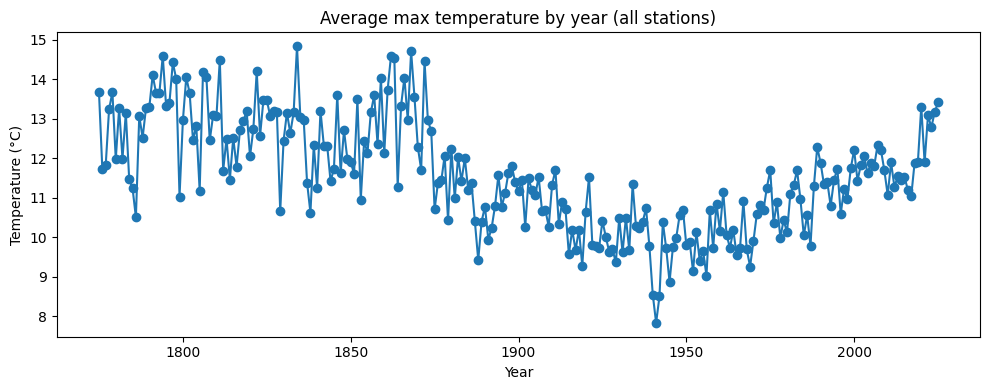

In [34]:
# Extract year
df['YEAR'] = df['DATE'].dt.year

# Average temperature by year (all stations together)
yearly_mean = df.groupby('YEAR')['TX_C'].mean().reset_index()

plt.figure(figsize=(10, 4))
plt.plot(yearly_mean['YEAR'], yearly_mean['TX_C'], marker='o')
plt.title('Average max temperature by year (all stations)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()


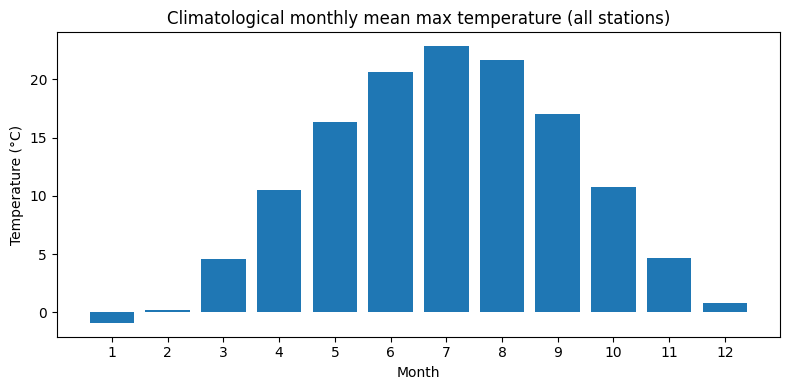

In [36]:
# Extract month
df['MONTH'] = df['DATE'].dt.month

monthly_mean = df.groupby('MONTH')['TX_C'].mean().reset_index()

plt.figure(figsize=(8, 4))
plt.bar(monthly_mean['MONTH'], monthly_mean['TX_C'])
plt.xticks(range(1, 13))
plt.title('Climatological monthly mean max temperature (all stations)')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()
